In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-07-30 14:07:15 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-07-30 14:07:15 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-07-30 14:07:15 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

[2025-07-30 14:07:18,150] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-07-30 14:07:18 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -c /tmp/tmpwbkn8an9/test.c -o /tmp/tmpwbkn8an9/test.o
2025-07-30 14:07:18 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat /tmp/tmpwbkn8an9/test.o -laio -o /tmp/tmpwbkn8an9/a.out


/disk/u/arnab/miniconda3/envs/connection/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


2025-07-30 14:07:18 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -c /tmp/tmpwanubnue/test.c -o /tmp/tmpwanubnue/test.o
2025-07-30 14:07:18 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat /tmp/tmpwanubnue/test.o -L/usr -L/usr/lib64 -lcufile -o /tmp/tmpwanubnue/a.out


/disk/u/arnab/miniconda3/envs/connection/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


2025-07-30 14:07:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-30 14:07:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-30 14:07:19 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-07-30 14:07:19 wandb.docker.auth DEBUG    No config file found


In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-07-30 14:07:20 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-07-30 14:07:20 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-07-30 14:07:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-07-30 14:07:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-07-30 14:08:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-07-30 14:08:10 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "64"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001",
    model_key.split("/")[-1],
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas["model<>layers<>5<>mlp<>gate_proj"]
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-30 14:08:25 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

In [8]:
from src.selection.data  import load_people_by_category, get_random_sample

people_by_category = load_people_by_category(tokenizer = mt.tokenizer)
list(people_by_category.keys())

2025-07-30 14:08:28 src.selection.data INFO     Loaded 16 categories


['actor',
 'singer',
 'comedian',
 'director',
 'basketball player',
 'football player',
 'soccer player',
 'tennis player',
 'golfer',
 'boxer',
 'news anchor',
 'journalist',
 'author',
 'fashion designer',
 'entrepreneur',
 'politician']

In [20]:
from scripts.locate_resolution_heads import SelectionSampleAttn

attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    mt.name.split("/")[-1]
)
files = sorted(os.listdir(attn_path))

#######################################################################
# LIMIT = 50
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 10 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

Loaded 10 files
Loaded 20 files
Loaded 30 files
Loaded 40 files
Loaded 50 files
Loaded 60 files
Loaded 70 files
Loaded 80 files
Loaded 90 files
Loaded 100 files
Loaded 110 files
Loaded 120 files
Loaded 130 files
Loaded 140 files
Loaded 150 files
Loaded 160 files
Loaded 170 files
Loaded 180 files
Loaded 190 files
Loaded 200 files
Loaded 210 files
Loaded 220 files
Loaded 230 files
Loaded 240 files
Loaded 250 files
Loaded 260 files
Loaded 270 files
Loaded 280 files
Loaded 290 files
Loaded 300 files
Loaded 310 files
Loaded 320 files
Loaded 330 files
Loaded 340 files
Loaded 350 files
Loaded 360 files
Loaded 370 files
Loaded 380 files
Loaded 390 files
Loaded 400 files
Loaded 410 files
Loaded 420 files
Loaded 430 files
Loaded 440 files
Loaded 450 files
Loaded 460 files
Loaded 470 files
Loaded 480 files
Loaded 490 files
Loaded 500 files


In [21]:
len(selection_attns)

500

In [22]:
from src.attention import visualize_attn_matrix

sample_idx = 35
layer_idx = 39
head_idx = 40

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.5011978149414062, 0.517578125, [0.01638031005859375, 0.005645751953125, 0.0003147125244140625, 0.0022411346435546875, 0.006317138671875])


In [47]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([64, 80])

In [48]:
resolution_scores[19, 35]

tensor(0.2730)

2025-07-30 16:30:08 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f98e992a790>


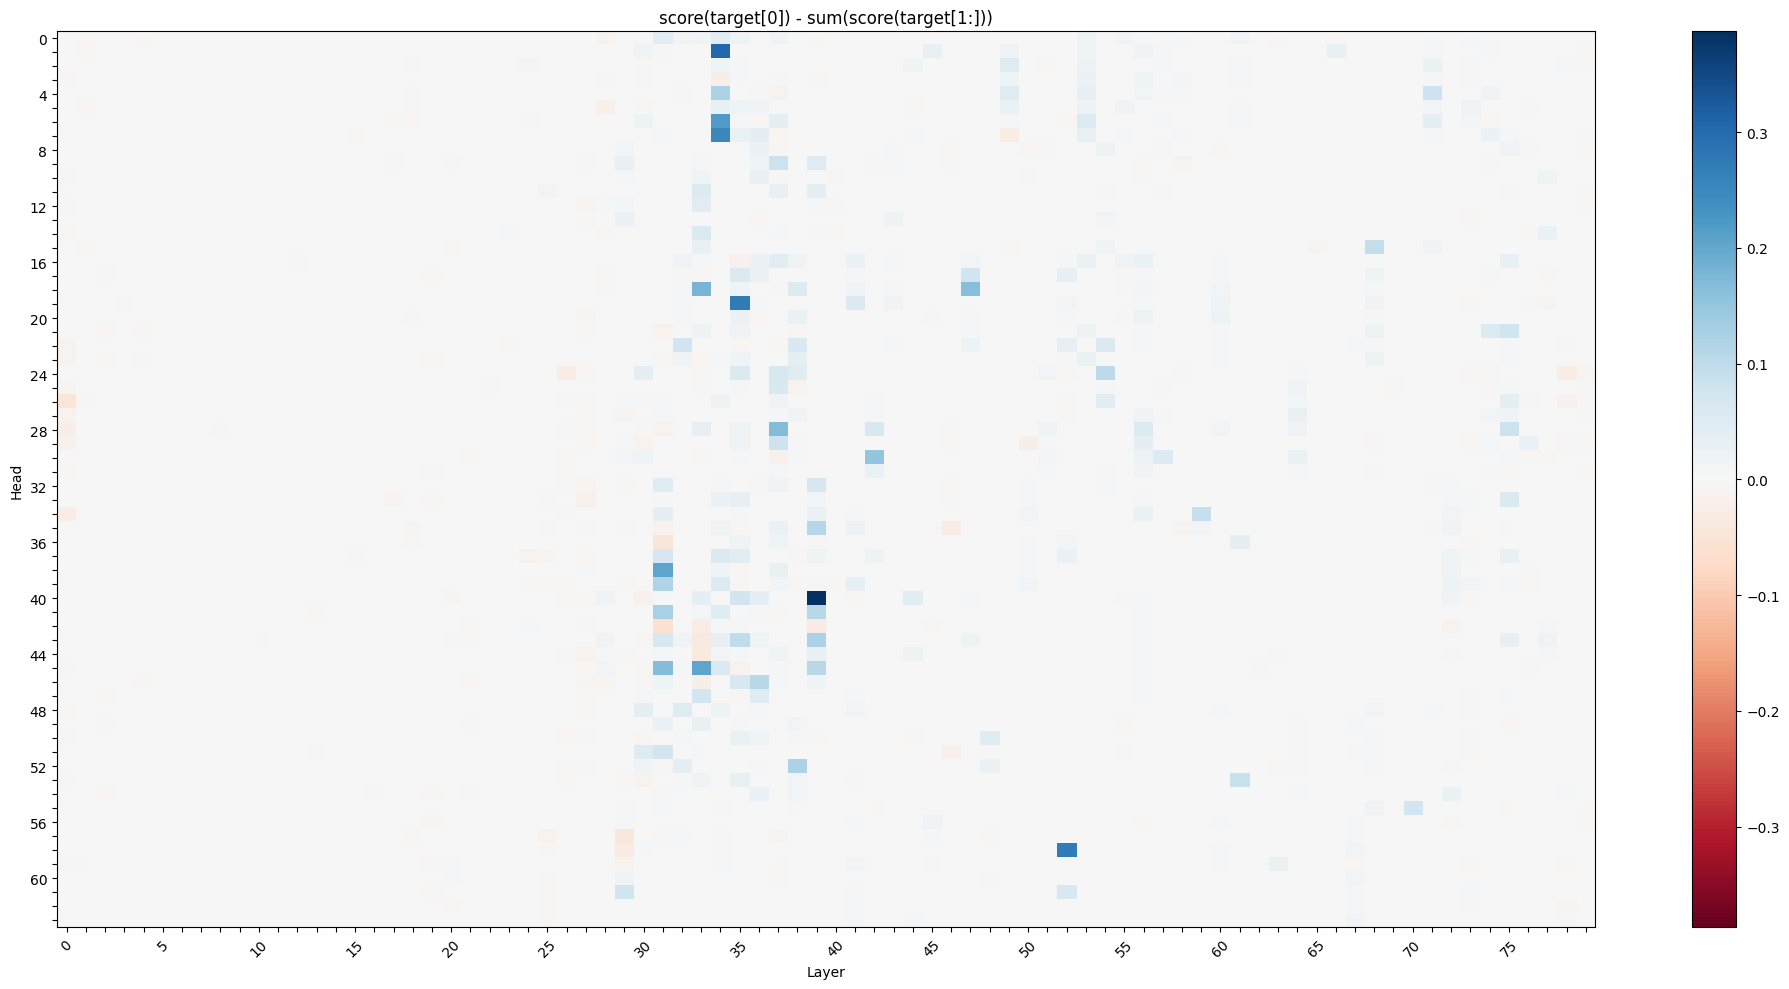

Layer 39, Head 40: 0.3871
Layer 34, Head 1: 0.3051
Layer 35, Head 19: 0.2730
Layer 52, Head 58: 0.2693
Layer 34, Head 7: 0.2488
Layer 34, Head 6: 0.2199
Layer 31, Head 38: 0.2036
Layer 33, Head 45: 0.2034
Layer 33, Head 18: 0.1794
Layer 37, Head 28: 0.1679
Layer 31, Head 45: 0.1674
Layer 47, Head 18: 0.1654
Layer 42, Head 30: 0.1535
Layer 31, Head 41: 0.1264
Layer 38, Head 52: 0.1239


In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [10]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id
from src.selection.data import SelectionSample
from src.functional import predict_next_token

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


def get_counterfactual_samples_on_pivot_entity(
    patch_category=None, clean_category=None
):
    if patch_category is None:
        patch_category = random.choice(list(people_by_category.keys()))

    patch_subj, patch_obj = random.sample(people_by_category[patch_category].values, 2)
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(
            list(set(people_by_category.keys()) - {patch_category})
        )
    clean_subj, clean_obj = random.sample(people_by_category[clean_category].values, 2)
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    distractors = []
    other_categories = random.sample(
        list(set(people_by_category.keys()) - {patch_category, clean_category}),
        k=N_DISTRACTORS - 1,
    )

    for other_category in other_categories:
        distractors.append(
            random.choice(
                (
                    people_by_category[other_category]
                    - KeyedSet(
                        [patch_obj, clean_obj] + distractors, tokenizer=mt.tokenizer
                    )
                ).values
            )
        )

    patch_options = [patch_obj, clean_obj] + distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    clean_options = copy.deepcopy(patch_options)
    while (
        clean_options.index(clean_obj) == patch_obj_idx
        or clean_options.index(patch_obj) == patch_obj_idx
    ):
        random.shuffle(clean_options)

    clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        obj_idx=patch_obj_idx,
        obj_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        metadata={"category": patch_category},
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        obj_idx=clean_obj_idx,
        obj_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        metadata={
            "category": clean_category,
        },
    )

    for sample in [patch_sample, clean_sample]:
        pred = predict_next_token(
            mt=mt,
            inputs=sample.prompt,
        )[0]
        logger.info(f"{sample.subj} -> {sample.obj} | pred={[str(p) for p in pred]}")
        if pred[0].token_id != sample.obj_token_id:
            logger.error(
                f'Prediction mismatch: {pred[0].token_id}["{mt.tokenizer.decode(pred[0].token_id)}"] != {sample.obj_token_id}["{mt.tokenizer.decode(sample.obj_token_id)}"]'
            )
            return get_counterfactual_samples_on_pivot_entity()
        sample.prediction = pred

    return patch_sample, clean_sample

In [11]:
from src.selection.data import SelectionSample, get_random_sample

patch_sample, clean_sample = get_counterfactual_samples_on_pivot_entity(
    patch_category="politician",
    clean_category="actor"
)

print(patch_sample.prompt, " >> ", f'"{patch_sample.obj}"')
print(f"{[str(p) for p in patch_sample.prediction]}")
print(clean_sample.prompt, " >> ", f'"{clean_sample.obj}"')
print(f"{[str(p) for p in clean_sample.prediction]}")

2025-07-30 11:13:41 __main__ INFO     Patch category: politician, subject: Hillary Clinton, object: Nancy Pelosi
2025-07-30 11:13:41 __main__ INFO     Clean category: actor, subject: Ryan Reynolds, object: Morgan Freeman
2025-07-30 11:13:41 __main__ INFO     patch_obj_idx=3 | ['Ridley Scott', 'Morgan Freeman', 'Michael Connelly', 'Nancy Pelosi', 'Pete Davidson', 'Maggie Haberman']
2025-07-30 11:13:41 __main__ INFO     clean_obj_idx=1 | ['Ridley Scott', 'Morgan Freeman', 'Pete Davidson', 'Michael Connelly', 'Nancy Pelosi', 'Maggie Haberman']


2025-07-30 11:13:42 __main__ INFO     Hillary Clinton -> Nancy Pelosi | pred=['" Nancy"[35336] (p=0.711, logit=19.750)', '" The"[578] (p=0.140, logit=18.125)', '" Hillary"[15383] (p=0.058, logit=17.250)', '" \n"[720] (p=0.007, logit=15.125)', '" "[220] (p=0.007, logit=15.125)']
2025-07-30 11:13:42 __main__ INFO     Ryan Reynolds -> Morgan Freeman | pred=['" Morgan"[23809] (p=0.477, logit=18.875)', '" Pete"[37373] (p=0.175, logit=17.875)', '" The"[578] (p=0.094, logit=17.250)', '" None"[2290] (p=0.083, logit=17.125)', '" Ryan"[13960] (p=0.025, logit=15.938)']
Which person from the following list has their occupation in common with Hillary Clinton?
Options: Ridley Scott, Morgan Freeman, Michael Connelly, Nancy Pelosi, Pete Davidson, Maggie Haberman.
Ans:  >>  "Nancy Pelosi"
['" Nancy"[35336] (p=0.711, logit=19.750)', '" The"[578] (p=0.140, logit=18.125)', '" Hillary"[15383] (p=0.058, logit=17.250)', '" \n"[720] (p=0.007, logit=15.125)', '" "[220] (p=0.007, logit=15.125)']
Which person fr

In [12]:
# patch_sample, clean_sample = clean_sample, patch_sample

In [13]:
from src.tokens import prepare_input
from src.utils.typing import TokenizerOutput

clean_tokenized = prepare_input(
    tokenizer=mt,
    prompts=clean_sample.prompt,
    return_offsets_mapping=True
)

patch_tokenized = prepare_input(
    tokenizer=mt,
    prompts=patch_sample.prompt,
    return_offsets_mapping=True
)

## ATTN module patterns (layerwise average of heads)

In [17]:
from src.attention import get_attention_matrices
from src.functional import interpret_logits
from src.attention import visualize_average_attn_matrix


clean_attn_matrices = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    value_weighted=False,
    # patches = []
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=clean_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=[35, 47],
)

interpret_logits(tokenizer=mt, logits=clean_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------


[PredictedToken(token=' Morgan', prob=0.451171875, logit=18.75, token_id=23809, metadata=None),
 PredictedToken(token=' Pete', prob=0.1875, logit=17.875, token_id=37373, metadata=None),
 PredictedToken(token=' The', prob=0.1005859375, logit=17.25, token_id=578, metadata=None),
 PredictedToken(token=' None', prob=0.078125, logit=17.0, token_id=2290, metadata=None),
 PredictedToken(token=' Ryan', prob=0.027099609375, logit=15.9375, token_id=13960, metadata=None)]

In [18]:
# visualize_average_attn_matrix(
#     mt=mt,
#     attn_matrices=clean_attn_matrices,
#     prompt=clean_sample.prompt,
#     tokenized=clean_tokenized,
#     layer_window=range(30, 51, 1)
# )

In [19]:
patch_attn_matrices = get_attention_matrices(
    input=patch_tokenized,
    mt=mt,
    value_weighted=False,
    # patches = []
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=patch_attn_matrices,
    prompt=patch_sample.prompt,
    tokenized=patch_tokenized,
    layer_window=range(35, 36),
)

interpret_logits(tokenizer=mt, logits=patch_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------


[PredictedToken(token=' Nancy', prob=0.70703125, logit=19.75, token_id=35336, metadata=None),
 PredictedToken(token=' The', prob=0.1396484375, logit=18.125, token_id=578, metadata=None),
 PredictedToken(token=' Hillary', prob=0.05810546875, logit=17.25, token_id=15383, metadata=None),
 PredictedToken(token=' ', prob=0.00738525390625, logit=15.1875, token_id=220, metadata=None),
 PredictedToken(token=' \n', prob=0.006927490234375, logit=15.125, token_id=720, metadata=None)]

In [20]:
# visualize_average_attn_matrix(
#     mt=mt,
#     attn_matrices=patch_attn_matrices,
#     prompt=patch_sample.prompt,
#     tokenized=patch_tokenized,
#     layer_window=range(30, 51, 1)
# )

In [21]:
from src.functional import get_hs, PatchSpec
from src.attention import get_attention_matrices

mt.reset_forward()
input_module = mt.layer_name_format.format(35) + ".input_layernorm"
# input_module = mt.layer_name_format.format(34)

# predictive_tokens = [-3, -2, -1]
predictive_tokens = [-1]

patch_hs = get_hs(
    mt=mt,
    input=patch_tokenized,
    locations=[(input_module, tok_idx) for tok_idx in predictive_tokens],
    return_dict=True
)

int_attn_matrices = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    value_weighted=False,
    patches = [PatchSpec(
        location=(input_module, tok_idx),
        patch=patch_hs[(input_module, tok_idx)],
    ) for tok_idx in predictive_tokens]
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=int_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=[35, 47],
)

interpret_logits(tokenizer=mt, logits=int_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------


[PredictedToken(token=' Morgan', prob=0.333984375, logit=18.125, token_id=23809, metadata=None),
 PredictedToken(token=' None', prob=0.259765625, logit=17.875, token_id=2290, metadata=None),
 PredictedToken(token=' The', prob=0.08447265625, logit=16.75, token_id=578, metadata=None),
 PredictedToken(token=' Ryan', prob=0.05810546875, logit=16.375, token_id=13960, metadata=None),
 PredictedToken(token=' Pete', prob=0.045166015625, logit=16.125, token_id=37373, metadata=None)]

### Check if independent processing hypothesis holds
#### Because even after patching in inputs, last layer ATTN still gives an amount of attention to the clean obj tokens. Why?

In [22]:
clean_sample.options

['Ridley Scott',
 'Morgan Freeman',
 'Pete Davidson',
 'Michael Connelly',
 'Nancy Pelosi',
 'Maggie Haberman']

In [23]:
from src.tokens import find_token_range
from itertools import product

clean_tokenized = prepare_input(
    tokenizer=mt, prompts=clean_sample.prompt, return_offsets_mapping=True
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]

patches = []
for obj in clean_sample.options:
    obj_range = find_token_range(
        string=clean_sample.prompt,
        substring=obj,
        offset_mapping=clean_offsets,
        tokenizer=mt.tokenizer,
    )

    bare_prompt = f" {obj} is a person."
    bare_tokenized = prepare_input(
        tokenizer=mt, prompts=bare_prompt, return_offsets_mapping=True
    )
    bare_offsets = bare_tokenized.pop("offset_mapping")[0]
    bare_obj_range = find_token_range(
        string=bare_prompt,
        substring=obj,
        offset_mapping=bare_offsets,
        tokenizer=mt.tokenizer,
    )
    print(f"{obj} | {obj_range=} | {bare_obj_range=}")
    assert obj_range[1] - obj_range[0] == bare_obj_range[1] - bare_obj_range[0], (
        f"Object token ranges do not match: {obj_range} vs {bare_obj_range}"
    )

    bare_hs = get_hs(
        mt=mt,
        input=bare_tokenized,
        locations=list(product(mt.layer_names, list(range(*bare_obj_range)))),
        return_dict=True,
    )
    for bare_idx, clean_idx in zip(range(*bare_obj_range), range(*obj_range)):
        patches.extend(
            [
                PatchSpec(
                    location=(module_name, clean_idx),
                    patch=bare_hs[(module_name, bare_idx)],
                )
                for module_name in mt.layer_names
            ]
    )

patches.extend(
    [
        PatchSpec(
            location=(input_module, tok_idx),
            patch=patch_hs[(input_module, tok_idx)],
        )
        for tok_idx in predictive_tokens
    ]
)

obj_replaced_attn_matrices = get_attention_matrices(
    input=clean_tokenized, mt=mt, value_weighted=False, patches=patches
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=obj_replaced_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=range(35, 36),
)

interpret_logits(tokenizer=mt, logits=obj_replaced_attn_matrices.logits)

Ridley Scott | obj_range=(18, 20) | bare_obj_range=(1, 3)
Morgan Freeman | obj_range=(21, 23) | bare_obj_range=(1, 3)
Pete Davidson | obj_range=(24, 26) | bare_obj_range=(1, 3)
Michael Connelly | obj_range=(27, 30) | bare_obj_range=(1, 4)
Nancy Pelosi | obj_range=(31, 33) | bare_obj_range=(1, 3)
Maggie Haberman | obj_range=(34, 37) | bare_obj_range=(1, 4)
layer=35


--------------------------------------------------------------------------------


[PredictedToken(token=' None', prob=0.41796875, logit=18.0, token_id=2290, metadata=None),
 PredictedToken(token=' Morgan', prob=0.1982421875, logit=17.25, token_id=23809, metadata=None),
 PredictedToken(token=' The', prob=0.08251953125, logit=16.375, token_id=578, metadata=None),
 PredictedToken(token=' Ryan', prob=0.056640625, logit=16.0, token_id=13960, metadata=None),
 PredictedToken(token=' Pete', prob=0.050048828125, logit=15.875, token_id=37373, metadata=None)]

## Apply (targetted) Patchscope on different layers

In [149]:
tokenized = prepare_input(
    tokenizer=mt,
    prompts=sample.prompt,
    return_offsets_mapping=True,
)
offset_mapping = tokenized.pop("offset_mapping")[0]


NameError: name 'sample' is not defined

In [14]:
from src.tokens import find_token_range

subj_range = find_token_range(
    string=sample.prompt,
    substring=sample.subj,
    offset_mapping=offset_mapping,
    tokenizer=mt,
    occurrence=-1,
)

print(
    f'{subj_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*subj_range)])}"'
)

option_ranges = []

for option in sample.options:
    option_range = find_token_range(
        string=sample.prompt,
        substring=option,
        offset_mapping=offset_mapping,
        tokenizer=mt,
        occurrence=-1,
    )
    print(
        f'{option_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*option_range)])}"'
    )
    option_ranges.append(option_range)

subj_range=(13, 15) | " Trevor Noah"
option_range=(18, 20) | " Zion Williamson"
option_range=(21, 24) | " John Mulaney"
option_range=(25, 28) | " Ariana Grande"
option_range=(29, 31) | " Joe Scarborough"
option_range=(32, 36) | " Andrey Rublev"
option_range=(37, 41) | " Samuel L. Jackson"


In [15]:
from src.functional import patchscope, get_hs
from itertools import product

pred_range = (-2, 0)
token_ranges = [pred_range, subj_range] + option_ranges
token_indices = []
for rng in token_ranges:
    token_indices.extend(list(range(rng[0], rng[1])))

layers = mt.layer_names
locations = list(product(layers, token_indices))

hs = get_hs(mt=mt, input=tokenized, locations=locations, patches=[], return_dict=True)


########################################################################
context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

patch_layers = [5]
patch_layers = [mt.layer_name_format.format(idx) for idx in patch_layers]
########################################################################

context = context_prof
context_tok = prepare_input(
    prompts=context_prof, tokenizer=mt, return_offsets_mapping=True
)
cxt_offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=cxt_offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

for layer in mt.layer_names[::3]:
    print(f"\n{layer=}")
    for cur_rng in token_ranges:
        print(
            f'\n"{mt.tokenizer.decode(tokenized.input_ids[0][range(*cur_rng)])}" | {cur_rng=}'
        )
        for token_idx in range(cur_rng[0], cur_rng[1]):
            token = mt.tokenizer.decode(tokenized.input_ids[0][token_idx])
            ll_pred = patchscope(
                mt=mt,
                h=hs[(layer, token_idx)],
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            print(f'{token_idx=} ["{token}"] => {ll_fmt}')

    print("=" * 150)


layer='model.layers.0'

"Ans:" | cur_rng=(-2, 0)
token_idx=-2 ["Ans"] => ['"?\n"[p=0.05, l=11.19]', '" programmer"[p=0.04, l=11.00]', '"??"[p=0.03, l=10.88]', '"???"[p=0.03, l=10.75]', '" software"[p=0.03, l=10.75]', '" unknown"[p=0.03, l=10.62]', '" student"[p=0.02, l=10.44]', '" singer"[p=0.02, l=10.38]', '" entrepreneur"[p=0.02, l=10.38]', '" artist"[p=0.02, l=10.38]', '"?\n\n"[p=0.02, l=10.31]', '"?"[p=0.02, l=10.25]', '" politician"[p=0.01, l=10.00]', '" actor"[p=0.01, l=10.00]', '" ("[p=0.01, l=9.94]']
token_idx=-1 [":"] => ['"?\n"[p=0.22, l=13.75]', '"?\n\n"[p=0.15, l=13.38]', '"??"[p=0.09, l=12.81]', '"?"[p=0.08, l=12.75]', '"???"[p=0.06, l=12.50]', '" \n"[p=0.02, l=11.56]', '" lawyer"[p=0.02, l=11.50]', '" unknown"[p=0.01, l=11.00]', '" artist"[p=0.01, l=10.75]', '" politician"[p=0.01, l=10.62]', '" software"[p=0.01, l=10.56]', '" programmer"[p=0.01, l=10.50]', '" ("[p=0.01, l=10.25]', '" "[p=0.01, l=10.25]', '" \n\n"[p=0.01, l=10.25]']

" Trevor Noah" | cur_rng=(13, 15)
toke

## Individual Heads

In [24]:
from src.attention import visualize_attn_matrix

###############################################################
N_KV_GROUPS = 1  # individual heads
# N_KV_GROUPS = mt.config.num_key_value_heads  # grouped heads
N_HEADS = mt.config.num_attention_heads
LAYER_RANGE = range(mt.n_layer)
###############################################################

group_id_to_head_indices = {
    i: [i * N_KV_GROUPS + j for j in range(N_KV_GROUPS)]
    for i in range(N_HEADS // N_KV_GROUPS)
}
# attn_info = get_attention_matrices(
#     input=tokenized,
#     mt=mt,
#     # value_weighted=True,
#     patches=[],
# )
# attn_info.attention_matrices.shape

In [25]:
attn_info = {
    "clean": clean_attn_matrices,
    "corrupt": patch_attn_matrices,
    "patch": int_attn_matrices,
    "obj_replaced": obj_replaced_attn_matrices,
}

layer_name = 35

patch_obj_range = find_token_range(
    string=clean_sample.prompt,
    substring=patch_sample.obj,
    offset_mapping=clean_offsets,
    tokenizer=mt.tokenizer,
    occurrence=-1,
)

clean_obj_range = find_token_range(
    string=clean_sample.prompt,
    substring=clean_sample.obj,
    offset_mapping=clean_offsets,
    tokenizer=mt.tokenizer,
    occurrence=-1,
)


logger.debug(
    f'{patch_obj_range=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*patch_obj_range)])}"'
)
logger.debug(
    f'{clean_obj_range=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*clean_obj_range)])}"'
)

head_scores = []
run_type = "patch"
for head_idx in range(N_HEADS):
    attn_matrix = attn_info[run_type].attention_matrices[layer_name, head_idx]
    patch_obj_score = attn_matrix[-1][patch_obj_range[0] : patch_obj_range[1]].sum().item()
    clean_obj_score = attn_matrix[-1][clean_obj_range[0] : clean_obj_range[1]].sum().item()
    head_scores.append({
        "head_idx": head_idx,
        "patch_obj_score": patch_obj_score,
        "clean_obj_score": clean_obj_score,
        "diff": patch_obj_score - clean_obj_score,
    })

head_scores = sorted(head_scores, key=lambda x: x["diff"], reverse=True)
head_scores[:10]

2025-07-30 11:15:19 __main__ DEBUG    patch_obj_range=(31, 33) | " Nancy Pelosi"
2025-07-30 11:15:19 __main__ DEBUG    clean_obj_range=(21, 23) | " Morgan Freeman"


[{'head_idx': 19,
  'patch_obj_score': 0.2575225830078125,
  'clean_obj_score': 0.133453369140625,
  'diff': 0.1240692138671875},
 {'head_idx': 16,
  'patch_obj_score': 0.1187744140625,
  'clean_obj_score': 0.033599853515625,
  'diff': 0.085174560546875},
 {'head_idx': 37,
  'patch_obj_score': 0.08203125,
  'clean_obj_score': 0.01092529296875,
  'diff': 0.07110595703125},
 {'head_idx': 46,
  'patch_obj_score': 0.03350830078125,
  'clean_obj_score': 0.00485992431640625,
  'diff': 0.02864837646484375},
 {'head_idx': 33,
  'patch_obj_score': 0.0434417724609375,
  'clean_obj_score': 0.022735595703125,
  'diff': 0.0207061767578125},
 {'head_idx': 24,
  'patch_obj_score': 0.024505615234375,
  'clean_obj_score': 0.00676727294921875,
  'diff': 0.01773834228515625},
 {'head_idx': 7,
  'patch_obj_score': 0.03570556640625,
  'clean_obj_score': 0.02301025390625,
  'diff': 0.0126953125},
 {'head_idx': 5,
  'patch_obj_score': 0.024658203125,
  'clean_obj_score': 0.012298583984375,
  'diff': 0.012359

In [26]:
# for group_id in group_id_to_head_indices:
for group_id in [19, 46]:
    frm = group_id_to_head_indices[group_id][0]
    to = group_id_to_head_indices[group_id][-1]
    print(
        f"Layer {layer_name}, Group {group_id} (Heads {frm}-{to})"
    )
    for run_name in attn_info:
        attn_matrix = (
            torch.Tensor(
                attn_info[run_name].attention_matrices[layer_name, frm : to + 1]
            )
            .mean(dim=0)
            .squeeze()
        )

        tokenized = patch_tokenized if run_name == "corrupt" else clean_tokenized
        print(run_name, attn_matrix.shape, tokenized.input_ids.shape)

        visualize_attn_matrix(
            attn_matrix=attn_matrix,
            tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
            q_index=-1,
            start_from=1,
        )
    
    print("=" * 150)

Layer 35, Group 19 (Heads 19-19)
clean torch.Size([40, 40]) torch.Size([1, 40])


corrupt torch.Size([40, 40]) torch.Size([1, 40])


patch torch.Size([40, 40]) torch.Size([1, 40])


obj_replaced torch.Size([40, 40]) torch.Size([1, 40])


Layer 35, Group 46 (Heads 46-46)
clean torch.Size([40, 40]) torch.Size([1, 40])


corrupt torch.Size([40, 40]) torch.Size([1, 40])


patch torch.Size([40, 40]) torch.Size([1, 40])


obj_replaced torch.Size([40, 40]) torch.Size([1, 40])


## Interpreting the subspace the `query_proj` reads from (Failed)

In [718]:
from src.functional import get_hs
from src.functional import logit_lens, patchscope, get_module_nnsight

########################################################################
context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

patch_layers = [5]
patch_layers = [mt.layer_name_format.format(idx) for idx in patch_layers]
########################################################################

layer_name, head_idx = 35, 46
run_type = "corrupt"
tokenized = patch_tokenized if run_type == "corrupt" else clean_tokenized

print(
    attn_info[run_type].attention_matrices[layer_name, head_idx].shape,
    tokenized.input_ids.shape,
)

visualize_attn_matrix(
    attn_matrix=attn_info[run_type].attention_matrices[layer_name, head_idx],
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

input_module = mt.layer_name_format.format(35) + ".input_layernorm"
with mt.trace(tokenized) as trace:
    res_prev = get_module_nnsight(mt, input_module)
    head_inp = (
        res_prev.output.save()
        if "mlp" in input_module or "layernorm" in input_module
        else res_prev.output[0].save()
    )

print(f"{head_inp.shape=}")

ll_pred = logit_lens(
    mt=mt,
    h=head_inp[0, -1, :],
)
print(f"ll_pred={[str(pred) for pred in ll_pred]}")

patch_pred = patchscope(
    mt=mt,
    h=head_inp[0, -1, :],
    context=context_prof,
    placeholder="placeholder",
    patch_layers=patch_layers,
    k=15,
)
print(f"patch_pred={[str(pred) for pred in patch_pred]}")

(50, 50) torch.Size([1, 50])


head_inp.shape=torch.Size([1, 50, 8192])
ll_pred=['"ais"[2852] (p=0.006, logit=7.688)', '"adel"[15503] (p=0.004, logit=7.344)', '"JR"[85792] (p=0.004, logit=7.219)', '" dossier"[53576] (p=0.003, logit=6.938)', '"nelly"[87731] (p=0.003, logit=6.875)']
patch_pred=['"?\n"[18072] (p=0.161, logit=12.938)', '"?\n\n"[24688] (p=0.111, logit=12.562)', '" \n"[720] (p=0.046, logit=11.688)', '"?"[949] (p=0.046, logit=11.688)', '" ->"[1492] (p=0.041, logit=11.562)', '" profession"[4913] (p=0.030, logit=11.250)', '" ("[320] (p=0.025, logit=11.062)', '"\n\n"[271] (p=0.025, logit=11.062)', '"??"[9602] (p=0.017, logit=10.688)', '" entrepreneur"[29349] (p=0.016, logit=10.625)', '" lawyer"[15779] (p=0.016, logit=10.625)', '" \n\n"[4815] (p=0.012, logit=10.375)', '" ->\n"[12662] (p=0.010, logit=10.125)', '" artist"[10255] (p=0.009, logit=10.000)', '" "[220] (p=0.009, logit=10.000)']


In [719]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher
from src.functional import predict_next_token

mt.reset_forward()
attn_block = baukit.get_module(
    mt._model,
    mt.attn_module_name_format.format(layer_name),
)

patched_attn_matrices = {}
patched_head_contributions={}
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name = mt.attn_module_name_format.format(layer_name),
        save_attn_for=list(range(mt.config.num_attention_heads)),
        store_attn_matrices = patched_attn_matrices,
        store_head_contributions = patched_head_contributions,
    ),
    attn_block
)

patched_pred = predict_next_token(
    mt = mt,
    inputs = tokenized,
)

mt.reset_forward()

patched_pred

2025-07-24 11:31:50 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-07-24 11:31:50 src.hooking.llama_attention DEBUG    hidden_shape=(1, 50, -1, 128) | input_shape=torch.Size([1, 50]) | torch.Size([1, 50, 8192])
2025-07-24 11:31:51 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 50, 128]) | key_states.size()=torch.Size([1, 8, 50, 128]) | value_states.size()=torch.Size([1, 8, 50, 128])
o_proj_weight_split.size()=torch.Size([8192, 64, 128])
attn_output.size()=torch.Size([1, 50, 64, 128])


[[PredictedToken(token=' Olivia', prob=0.8125, logit=19.875, token_id=60387, metadata=None),
  PredictedToken(token=' None', prob=0.02783203125, logit=16.5, token_id=2290, metadata=None),
  PredictedToken(token=' The', prob=0.02783203125, logit=16.5, token_id=578, metadata=None),
  PredictedToken(token=' Ade', prob=0.021728515625, logit=16.25, token_id=63140, metadata=None),
  PredictedToken(token=' Christian', prob=0.016845703125, logit=16.0, token_id=9052, metadata=None)]]

In [720]:
from src.functional import logit_lens
print(f"{patched_attn_matrices[head_idx].shape=}")
print(f"{patched_head_contributions[head_idx].shape=}")

visualize_attn_matrix(
    attn_matrix=patched_attn_matrices[head_idx].squeeze(),
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

logit_lens(
    mt = mt,
    h = patched_head_contributions[head_idx][:, -1],
)

patched_attn_matrices[head_idx].shape=torch.Size([1, 50, 50])
patched_head_contributions[head_idx].shape=torch.Size([1, 50, 8192])


[PredictedToken(token='čan', prob=0.00433349609375, logit=7.75, token_id=109800, metadata=None),
 PredictedToken(token='ept', prob=0.0029754638671875, logit=7.375, token_id=109556, metadata=None),
 PredictedToken(token='acic', prob=0.0027923583984375, logit=7.3125, token_id=94257, metadata=None),
 PredictedToken(token=' ><?', prob=0.001861572265625, logit=6.90625, token_id=87252, metadata=None),
 PredictedToken(token='RAL', prob=0.001495361328125, logit=6.6875, token_id=52831, metadata=None)]

In [721]:
import baukit
attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_name))
print(f"{attn_module.head_dim=} | {attn_module.num_key_value_groups=}")
attn_module

attn_module.head_dim=128 | attn_module.num_key_value_groups=8


LlamaAttention(
  (q_proj): Linear(in_features=8192, out_features=8192, bias=False)
  (k_proj): Linear(in_features=8192, out_features=1024, bias=False)
  (v_proj): Linear(in_features=8192, out_features=1024, bias=False)
  (o_proj): Linear(in_features=8192, out_features=8192, bias=False)
)

In [722]:
from src.hooking.llama_attention import repeat_kv

with torch.no_grad():
    hidden_shape = (*tokenized.input_ids.shape, -1, attn_module.head_dim)
    query_states = attn_module.q_proj(head_inp).view(hidden_shape).transpose(1, 2)
    key_states = attn_module.k_proj(head_inp).view(hidden_shape).transpose(1, 2)
    value_states = attn_module.v_proj(head_inp).view(hidden_shape).transpose(1, 2)

    key_states = repeat_kv(key_states, n_rep=attn_module.num_key_value_groups)
    value_states = repeat_kv(value_states, n_rep=attn_module.num_key_value_groups)
    print(f"{query_states.shape=}, {key_states.shape=}, {value_states.shape=}")

query_states.shape=torch.Size([1, 64, 50, 128]), key_states.shape=torch.Size([1, 64, 50, 128]), value_states.shape=torch.Size([1, 64, 50, 128])


In [723]:
head_query_out = query_states[:, head_idx, :, :]
head_key_out = key_states[:, head_idx, :, :]
head_query_out.shape, head_key_out.shape, head_inp.shape

(torch.Size([1, 50, 128]), torch.Size([1, 50, 128]), torch.Size([1, 50, 8192]))

In [724]:
q_proj_weight_split = attn_module.q_proj.weight.view(
    N_HEADS, attn_module.head_dim, attn_module.q_proj.in_features
)

print(f"{q_proj_weight_split.shape=}")
head_q_proj_weight = q_proj_weight_split[head_idx]
print(f"{head_q_proj_weight.shape=}")

head_query_out_2 = head_inp @ head_q_proj_weight.T
print(f"{head_query_out_2.shape=}")

# ------------------------------------------------------------------------
k_proj_weight_split = attn_module.k_proj.weight.view(
    N_HEADS // attn_module.num_key_value_groups, attn_module.head_dim, attn_module.k_proj.in_features
)
print(f"{k_proj_weight_split.shape=}")
head_k_proj_weight = k_proj_weight_split[head_idx // attn_module.num_key_value_groups]
print(f"{head_k_proj_weight.shape=}")  

head_key_out_2 = head_inp @ head_k_proj_weight.T
print(f"{head_key_out_2.shape=}")

q_proj_weight_split.shape=torch.Size([64, 128, 8192])
head_q_proj_weight.shape=torch.Size([128, 8192])
head_query_out_2.shape=torch.Size([1, 50, 128])
k_proj_weight_split.shape=torch.Size([8, 128, 8192])
head_k_proj_weight.shape=torch.Size([128, 8192])
head_key_out_2.shape=torch.Size([1, 50, 128])


In [725]:
print(torch.allclose(head_query_out, head_query_out_2, atol=1e-1))
print(torch.allclose(head_key_out, head_key_out_2, atol=1e-1))

True
True


In [726]:
import math
scale_factor = 1 / math.sqrt(head_query_out_2.shape[-1])

attn_pattern_2 = torch.einsum(
    "b i d, b j d -> b i j",
    head_query_out_2,
    head_key_out_2,
).squeeze() * scale_factor

attn_pattern_2 = attn_pattern_2.softmax(dim=-1)

visualize_attn_matrix(
    attn_matrix=attn_pattern_2,
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

In [658]:
@torch.inference_mode()
def inverse_rms_norm(output, weight, eps=1e-5):
    """
    Compute an input that would produce the given output when passed through RMSNorm.
    Note: The inverse is not unique as RMSNorm loses scale information.
    This returns one valid pre-image.
    
    Args:
        output: The output from RMSNorm forward pass
        weight: The weight parameter from RMSNorm
        eps: The epsilon value used in RMSNorm
    
    Returns:
        hidden_states: An input that would produce the given output
    """
    normalized = output / weight
    normalized = normalized.to(torch.float32)
    
    normalized_rms = torch.sqrt(normalized.pow(2).mean(-1, keepdim=True))
    rms_sq = (normalized_rms.pow(2) * eps) / (1 - normalized_rms.pow(2) + 1e-8)
    rms_val = torch.sqrt(torch.clamp(rms_sq, min=0))
    
    scale = torch.sqrt(rms_val.pow(2) + eps)
    hidden_states = normalized * scale
    
    return hidden_states.to(output.dtype)

import baukit
input_ln = baukit.get_module(mt._model, mt.layer_name_format.format(layer_name) + ".input_layernorm")

inp = torch.randn(mt.n_embd, dtype=mt.dtype, device=mt.device)
out = input_ln(inp)
inp_2 = inverse_rms_norm(out, input_ln.weight, input_ln.variance_epsilon)
inp_2 = inp_2 * (inp.norm().item() / inp_2.norm().item())  # Rescale to match original norm

print(f"{out.shape=} | {inp.shape} | {inp_2.shape=}")
torch.allclose(inp, inp_2.to(inp.device), atol=1e-1)

out.shape=torch.Size([8192]) | torch.Size([8192]) | inp_2.shape=torch.Size([8192])


True

In [659]:
with torch.no_grad():
    head_q_proj = head_q_proj_weight.to(torch.float32)
    proj_matrix = head_q_proj.T @ torch.linalg.pinv(head_q_proj @ head_q_proj.T) @ head_q_proj
    head_query_read = head_inp @ proj_matrix.to(mt.dtype).T

head_query_read = inverse_rms_norm(
    head_query_read[:, -1].squeeze(), input_ln.weight, input_ln.variance_epsilon
)

ll_pred = logit_lens(
    mt = mt,
    h = head_query_read,
    k=15
)
print(f'll_pred={[str(pred) for pred in ll_pred]}')

patch_pred = patchscope(
    mt=mt,
    h=head_query_read,
    context=context_prof,
    placeholder="placeholder",
    patch_layers=patch_layers,
    k=15,
)
print(f'patch_pred={[str(pred) for pred in patch_pred]}')

proj_matrix.shape

ll_pred=['" latter"[15629] (p=0.000, logit=2.625)', '"undry"[28346] (p=0.000, logit=1.844)', '" "[220] (p=0.000, logit=1.695)', '"adolu"[112288] (p=0.000, logit=1.625)', '"acular"[23868] (p=0.000, logit=1.586)', '"ongan"[83388] (p=0.000, logit=1.547)', '"inar"[14080] (p=0.000, logit=1.516)', '" fu"[18922] (p=0.000, logit=1.477)', '" fuels"[40373] (p=0.000, logit=1.477)', '"ременно"[117379] (p=0.000, logit=1.469)', '" Wagner"[52475] (p=0.000, logit=1.469)', '"_argv"[74663] (p=0.000, logit=1.469)', '" impres"[77998] (p=0.000, logit=1.461)', '"inerary"[52653] (p=0.000, logit=1.453)', '" GC"[23186] (p=0.000, logit=1.445)']
patch_pred=['" unknown"[9987] (p=0.075, logit=11.188)', '"??"[9602] (p=0.055, logit=10.875)', '"?\n"[18072] (p=0.052, logit=10.812)', '"???"[52417] (p=0.043, logit=10.625)', '" programmer"[48888] (p=0.030, logit=10.250)', '"?\n\n"[24688] (p=0.028, logit=10.188)', '"?"[949] (p=0.026, logit=10.125)', '" invalid"[8482] (p=0.018, logit=9.750)', '" error"[1493] (p=0.018, logi

torch.Size([8192, 8192])

## Checking the presence of information with averaged probes

### Calculate the probe directions

In [437]:
device_map = get_device_map(mt.name, 80, n_gpus=8)

def module_to_device(module_name):
    for key in device_map:
        if module_name.startswith(key):
            return f"cuda:{device_map[key]}"
    return "cpu"

module_to_device(mt.mlp_module_name_format.format(20))

'cuda:2'

In [484]:
import numpy as np

cached_states_dir = "/disk/u/arnab/Codes/Projects/retrieval/results/selection/Llama-3.3-70B-Instruct/profession/cached_states/last_token"
LIMIT = len(os.listdir(cached_states_dir))
# LIMIT = 1000

cached_states_by_category = {}

for idx, file_name in enumerate(os.listdir(cached_states_dir)[:LIMIT]):
    sample_states = np.load(
        os.path.join(cached_states_dir, file_name), allow_pickle=True
    )
    category = sample_states["sample"].item()["metadata"]["category"]
    if category not in cached_states_by_category:
        cached_states_by_category[category] = {}
    states = {}
    for key, value in sample_states["states"].item().items():
        layer_name, token_idx = key.split("_<>_")
        device = module_to_device(layer_name)
        states[layer_name] = torch.Tensor(value).to(mt.dtype).to(device)

    for layer_name in states:
        if layer_name not in cached_states_by_category[category]:
            cached_states_by_category[category][layer_name] = []
        cached_states_by_category[category][layer_name].append(states[layer_name])

    if (idx + 1) % 1000 == 0 or idx + 1 == LIMIT:
        logger.info(
            f"Processed {idx+1}/{LIMIT} files... ({(idx+1) / LIMIT * 100:.2f}%)"
        )

# cached_states_by_category = {
#     layer_name: torch.stack(cached_states_by_category[layer_name], dim=0)
#     .to(mt.dtype)
#     .to(module_to_device(layer_name))
#     for layer_name in cached_states_by_category
# }

random_module = random.choice(list(cached_states_by_category["boxer"].keys()))

for category in cached_states_by_category:
    print(f"Processing category: {category} | {len(cached_states_by_category[category][random_module])} examples")
    for layer_name in cached_states_by_category[category]:
        cached_states_by_category[category][layer_name] = torch.stack(
            cached_states_by_category[category][layer_name], dim=0
        ).mean(dim=0).to(mt.dtype).to(module_to_device(layer_name))

free_gpu_cache()

2025-07-23 17:49:47 __main__ INFO     Processed 1000/12000 files... (8.33%)
2025-07-23 17:50:37 __main__ INFO     Processed 2000/12000 files... (16.67%)
2025-07-23 17:51:29 __main__ INFO     Processed 3000/12000 files... (25.00%)
2025-07-23 17:52:21 __main__ INFO     Processed 4000/12000 files... (33.33%)
2025-07-23 17:53:12 __main__ INFO     Processed 5000/12000 files... (41.67%)
2025-07-23 17:54:03 __main__ INFO     Processed 6000/12000 files... (50.00%)
2025-07-23 17:54:55 __main__ INFO     Processed 7000/12000 files... (58.33%)
2025-07-23 17:55:45 __main__ INFO     Processed 8000/12000 files... (66.67%)
2025-07-23 17:56:37 __main__ INFO     Processed 9000/12000 files... (75.00%)
2025-07-23 17:57:28 __main__ INFO     Processed 10000/12000 files... (83.33%)
2025-07-23 17:58:18 __main__ INFO     Processed 11000/12000 files... (91.67%)
2025-07-23 17:59:11 __main__ INFO     Processed 12000/12000 files... (100.00%)
Processing category: news anchor | 739 examples
Processing category: tenn

In [485]:
##################################################################
probe_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    mt.name.split("/")[-1],
    "profession",
    "probe_directions",
)
##################################################################
os.makedirs(probe_dir, exist_ok=True)

In [486]:
from src.functional import detensorize
for category in cached_states_by_category:
    module_states = detensorize(cached_states_by_category[category])
    np.savez_compressed(
        os.path.join(probe_dir, f"{category}.npz"),
        **module_states,
    )

### Load the probe directions

In [25]:
import numpy as np
##################################################################
probe_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    mt.name.split("/")[-1],
    "profession",
    "probe_directions",
)
##################################################################

probe_directions = {}
for category in os.listdir(probe_dir):
    if not category.endswith(".npz"):
        continue
    category = category[:-4]  # Remove the .npz extension
    logger.info(f"Loading probe directions for category: {category}")
    probe_directions[category] = {}
    npz_load = np.load(os.path.join(probe_dir, f"{category}.npz"), allow_pickle=True)
    for key in npz_load:
        probe_directions[category][key] = (
            torch.Tensor(npz_load[key])
            .to(mt.dtype)
            .to(mt.device)
        )

2025-07-24 17:47:13 __main__ INFO     Loading probe directions for category: entrepreneur


2025-07-24 17:47:13 __main__ INFO     Loading probe directions for category: tennis player
2025-07-24 17:47:13 __main__ INFO     Loading probe directions for category: singer
2025-07-24 17:47:13 __main__ INFO     Loading probe directions for category: author
2025-07-24 17:47:13 __main__ INFO     Loading probe directions for category: journalist
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: basketball player
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: fashion designer
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: soccer player
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: football player
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: actor
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: comedian
2025-07-24 17:47:14 __main__ INFO     Loading probe directions for category: golfer
2025-07-24 17:47:14 __main_

### Utils

In [26]:
from matplotlib import pyplot as plt
from dataclasses import dataclass


def whiten(h, mean_d):
    """
    Remove the average direction from the given direction.
    """
    # return h - mean_h
    return h - (torch.dot(h, mean_d) / mean_d.norm() ** 2) * mean_d


def centered_cosine_similarity(h, d, avg_d):
    """
    Compute the cosine similarity between two vectors after centering them.
    """
    h_centered = whiten(h, avg_d)
    d_centered = whiten(d, avg_d)
    return torch.nn.functional.cosine_similarity(
        h_centered.unsqueeze(0), d_centered.unsqueeze(0)
    ).item()


@dataclass
class MeanProbes:
    probe_directions: dict[str, torch.Tensor]
    token_positions: list[int] = None

    def __post_init__(self):
        logger.info("calculating average directions across categories...")
        rand_key = random.choice(self.categories)
        average_directions = {}
        for layer_name in self.probe_directions[rand_key]:
            average_directions[layer_name] = torch.stack(
                [
                    self.probe_directions[category][layer_name]
                    for category in self.probe_directions
                ],
                dim=0,
            ).mean(dim=0)
        self.average_directions = average_directions

    def apply(self, h, module_name):
        rand_key = random.choice(self.categories)
        assert (
            module_name in self.probe_directions[rand_key]
        ), f"Module {module_name} not found in probe directions."
        score_per_category = {}
        for category in self.probe_directions:
            d = self.probe_directions[category][module_name].to(mt.dtype).to(mt.device)
            avg = self.average_directions[module_name].to(mt.dtype).to(mt.device)
            score = centered_cosine_similarity(h, d, avg)
            score_per_category[category] = score
        return score_per_category

    def apply_all_layers(self, hs: dict[str, torch.Tensor], layer_names=list[str]):
        results = {}
        for layer_name in layer_names:
            if layer_name not in hs:
                continue
            h = hs[layer_name].to(mt.dtype).to(mt.device)
            results[layer_name] = self.apply(h, layer_name)
        return results

    @property
    def categories(self):
        return list(self.probe_directions.keys())

    @property
    def layer_names(self):
        return list(self.probe_directions[self.categories[0]].keys())

    @staticmethod
    def get_evolution_of_scores(scores, correct_concept: str):
        """
        For each layer, plots the difference between the score(correct_concept) - max([score_concept for concept in categories if concept != correct_concept])
        """
        layer_indices = list(range(len(scores)))
        correct_scores = [
            scores[layer_name][correct_concept]
            for layer_name in scores
        ]
        max_other_scores = [
            max(
                [
                    scores[layer_name][category]
                    for category in scores[layer_name]
                    if category != correct_concept
                ]
            )
            for layer_name in scores
        ]
        differences = [
            correct_scores[i] - max_other_scores[i]
            for i in range(len(layer_indices))
        ]
        return differences

    @staticmethod
    def bar_chart_per_layer(
        scores: dict[str, dict[str, float]],
        highlight_categories: list[str] = None,
        ylim=(-1, +1),
    ):
        categories = list(scores[list(scores.keys())[0]].keys())
        for layer_name in scores:
            plt.figure(figsize=(20, 5))
            plt.title(f"{layer_name}")
            plt.bar(
                categories,
                [scores[layer_name][category] for category in categories],
                label=layer_name,
                color="blue",
            )
            if highlight_categories:
                for highlight in highlight_categories:
                    if highlight in categories:
                        plt.bar(
                            highlight,
                            [scores[layer_name][highlight]],
                            color="crimson",
                        )
                        plt.hlines(
                            y=[scores[layer_name][highlight]],
                            xmin=0,
                            xmax=len(categories) - 1,
                            colors="black",
                            linestyles="dashed",
                            alpha=0.5,
                            linewidth=0.5,
                        )

            plt.hlines(
                y=0,
                xmin=0,
                xmax=len(categories) - 1,
                colors="darkred",
                # linestyles="dashed",
            )

            plt.ylim(*ylim)
            plt.xticks(rotation=90)
            plt.show()

            sorted_categories = sorted(
                [(category, score) for category, score in scores[layer_name].items()],
                key=lambda x: x[1],
                reverse=True,
            )
            logger.info(f"{layer_name} = {sorted_categories}")


mean_probes = MeanProbes(probe_directions=probe_directions)
mean_probes.categories

2025-07-24 17:47:18 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-07-24 17:47:18 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-07-24 17:47:18 matplotlib DEBUG    interactive is False
2025-07-24 17:47:18 matplotlib DEBUG    platform is linux
2025-07-24 17:47:18 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-07-24 17:47:18 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-07-24 17:47:18 __main__ INFO     calculating average directions across categories...


['entrepreneur',
 'tennis player',
 'singer',
 'author',
 'journalist',
 'basketball player',
 'fashion designer',
 'soccer player',
 'football player',
 'actor',
 'comedian',
 'golfer',
 'boxer',
 'politician',
 'news anchor',
 'director']

2025-07-24 17:47:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-24 17:47:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-24 17:47:25 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-24 17:47:25 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-24 17:47:25 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='n

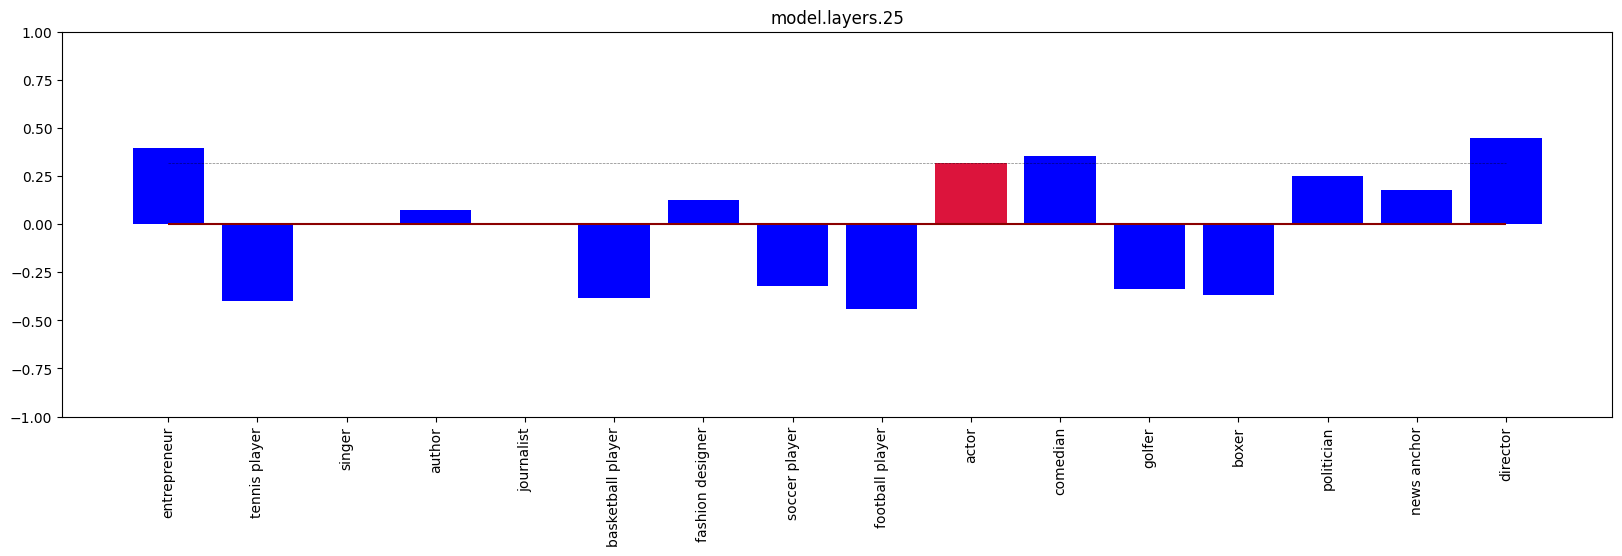

2025-07-24 17:47:26 __main__ INFO     model.layers.25 = [('director', 0.44921875), ('entrepreneur', 0.396484375), ('comedian', 0.35546875), ('actor', 0.314453125), ('politician', 0.248046875), ('news anchor', 0.177734375), ('fashion designer', 0.123046875), ('author', 0.07373046875), ('singer', -0.0064697265625), ('journalist', -0.00714111328125), ('soccer player', -0.32421875), ('golfer', -0.337890625), ('boxer', -0.3671875), ('basketball player', -0.3828125), ('tennis player', -0.3984375), ('football player', -0.439453125)]


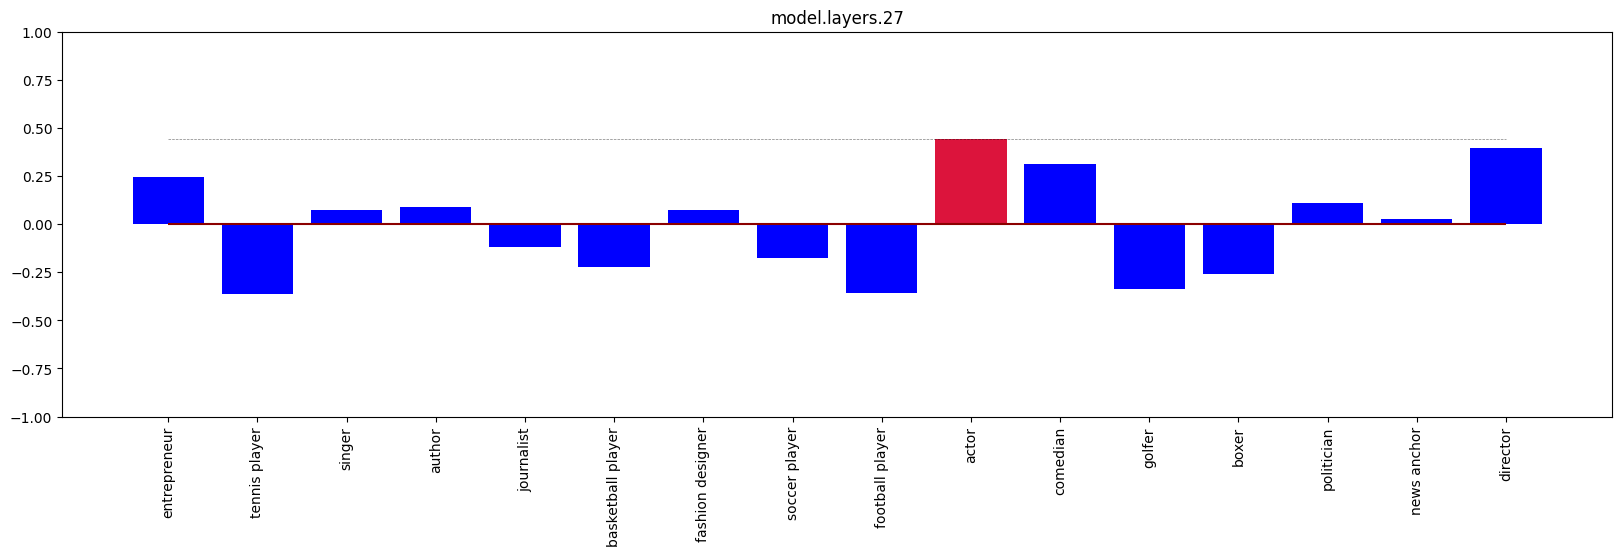

2025-07-24 17:47:26 __main__ INFO     model.layers.27 = [('actor', 0.443359375), ('director', 0.39453125), ('comedian', 0.310546875), ('entrepreneur', 0.24609375), ('politician', 0.11083984375), ('author', 0.0859375), ('singer', 0.072265625), ('fashion designer', 0.0712890625), ('news anchor', 0.0240478515625), ('journalist', -0.12109375), ('soccer player', -0.17578125), ('basketball player', -0.224609375), ('boxer', -0.259765625), ('golfer', -0.33984375), ('football player', -0.357421875), ('tennis player', -0.36328125)]


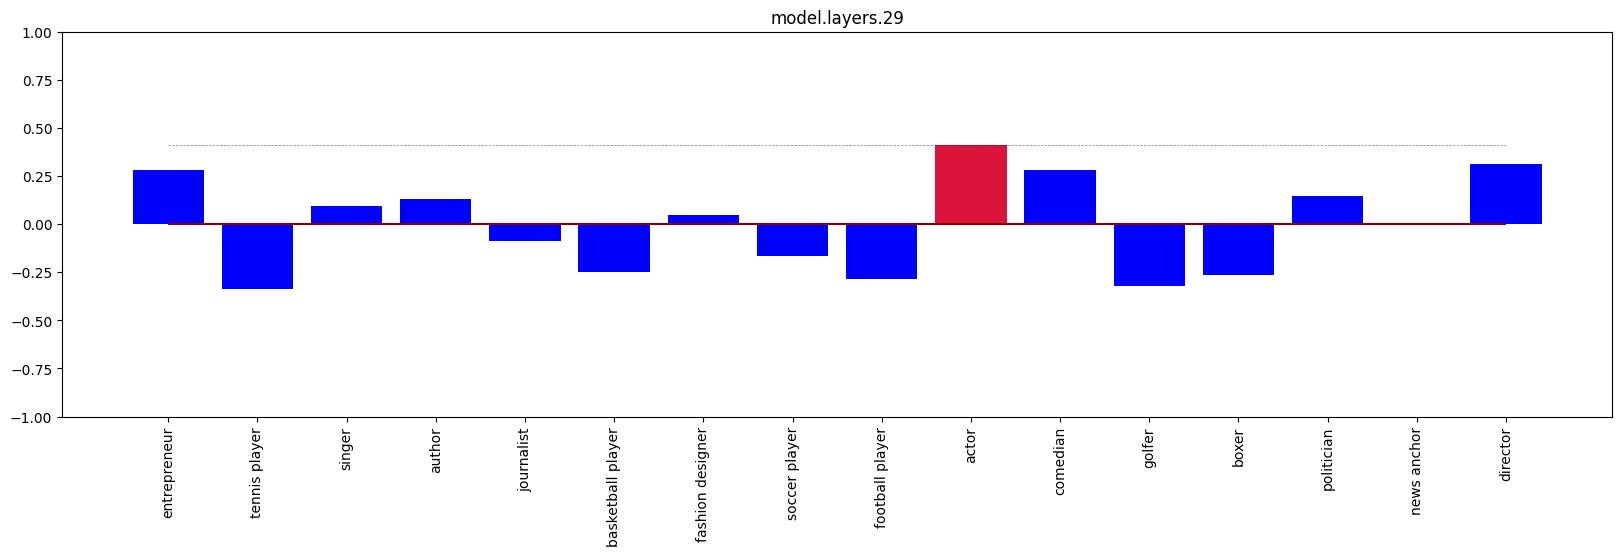

2025-07-24 17:47:26 __main__ INFO     model.layers.29 = [('actor', 0.412109375), ('director', 0.3125), ('entrepreneur', 0.28125), ('comedian', 0.279296875), ('politician', 0.1455078125), ('author', 0.1279296875), ('singer', 0.0927734375), ('fashion designer', 0.04541015625), ('news anchor', -0.005462646484375), ('journalist', -0.08837890625), ('soccer player', -0.166015625), ('basketball player', -0.2470703125), ('boxer', -0.265625), ('football player', -0.287109375), ('golfer', -0.32421875), ('tennis player', -0.337890625)]


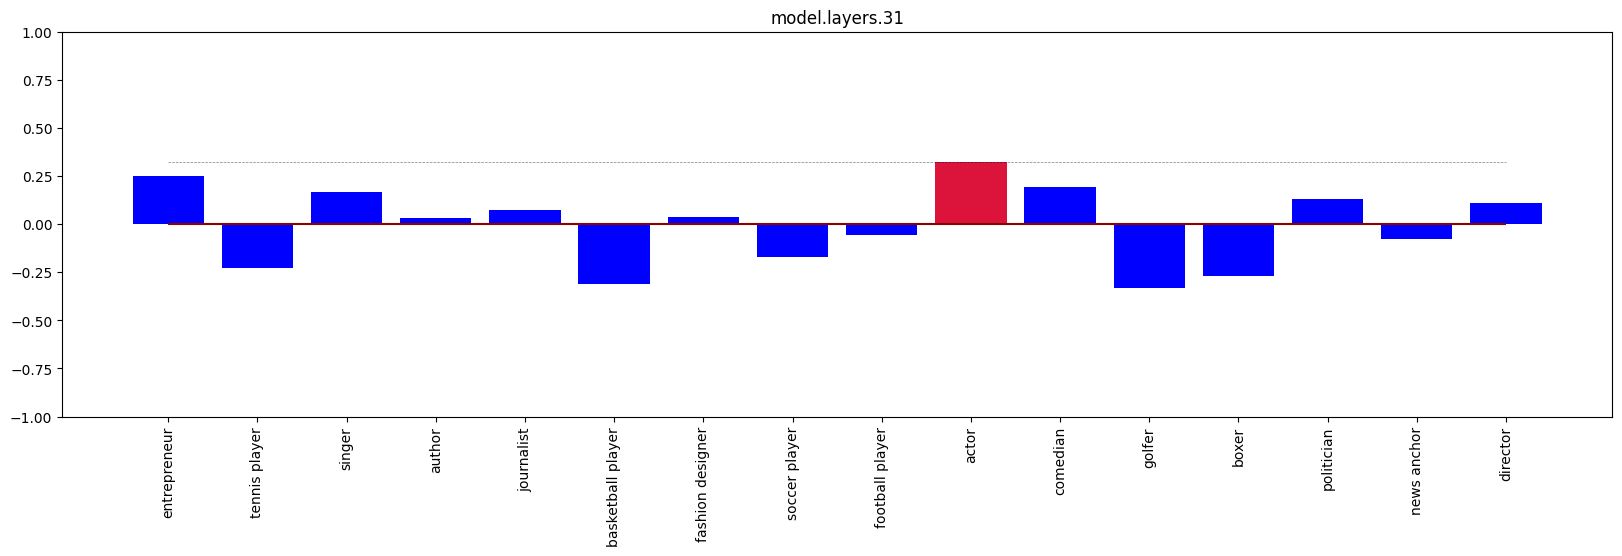

2025-07-24 17:47:27 __main__ INFO     model.layers.31 = [('actor', 0.3203125), ('entrepreneur', 0.251953125), ('comedian', 0.1943359375), ('singer', 0.1650390625), ('politician', 0.12890625), ('director', 0.1103515625), ('journalist', 0.07177734375), ('fashion designer', 0.038818359375), ('author', 0.02978515625), ('football player', -0.058349609375), ('news anchor', -0.07861328125), ('soccer player', -0.1708984375), ('tennis player', -0.2265625), ('boxer', -0.271484375), ('basketball player', -0.310546875), ('golfer', -0.330078125)]


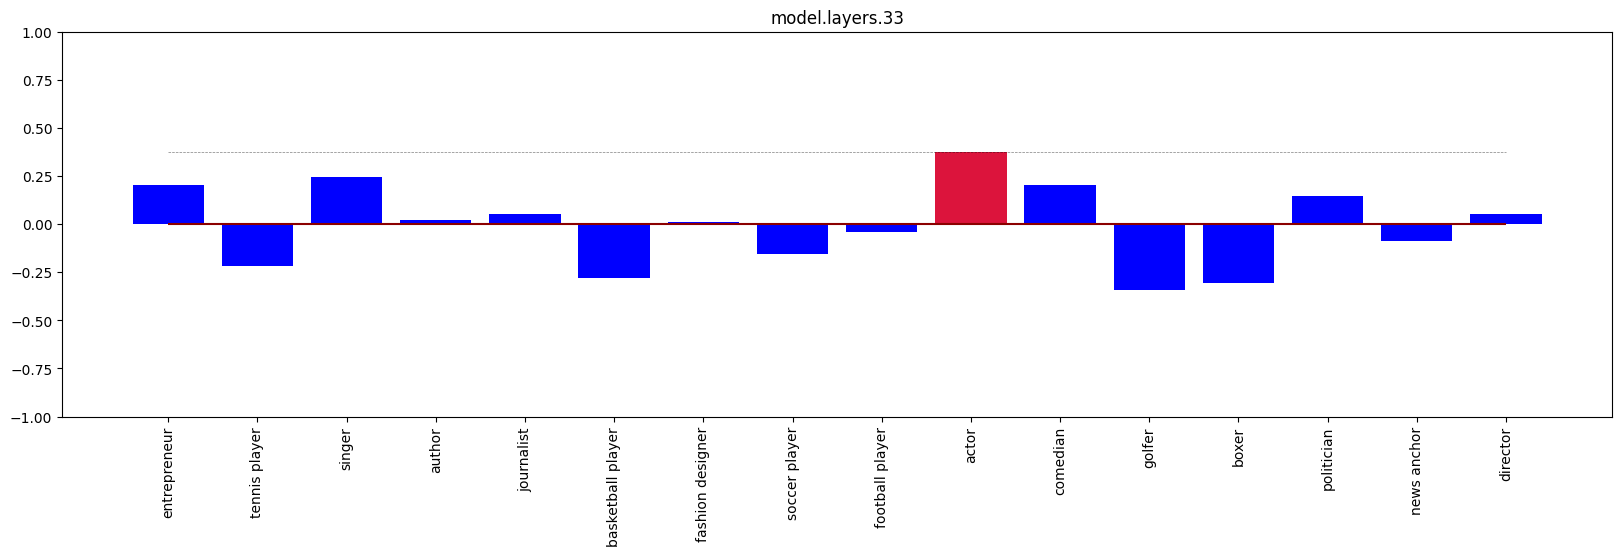

2025-07-24 17:47:27 __main__ INFO     model.layers.33 = [('actor', 0.375), ('singer', 0.2421875), ('comedian', 0.2041015625), ('entrepreneur', 0.203125), ('politician', 0.1455078125), ('director', 0.05419921875), ('journalist', 0.052001953125), ('author', 0.0228271484375), ('fashion designer', 0.0086669921875), ('football player', -0.04052734375), ('news anchor', -0.08984375), ('soccer player', -0.1572265625), ('tennis player', -0.2197265625), ('basketball player', -0.279296875), ('boxer', -0.306640625), ('golfer', -0.34375)]


In [27]:
from src.functional import get_hs

# sample = patch_sample
sample = clean_sample
locations = [
    (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
]
# locations = [(mt.layer_name_format.format(35), -1)]

hs = get_hs(mt=mt, input=sample.prompt, locations=locations, return_dict=True)
hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}

layers = [
    mt.layer_name_format.format(layer_idx)
    for layer_idx in list(set(list(range(0, mt.n_layer, 5)) + list(range(30, 40))))
]
layerwise_scores = mean_probes.apply_all_layers(
    hs=hs,
    layer_names=hs.keys(),
)

# evolution_of_scores = MeanProbes.get_evolution_of_scores(
#     scores=layerwise_scores,
#     correct_concept=sample.metadata["category"],
# )

# plt.figure(figsize=(10, 5))
# plt.plot(range(len(evolution_of_scores)),evolution_of_scores, marker='o', markersize=3, alpha=0.7)
# plt.xlabel("Layer Index")
# plt.ylabel("Score Difference")
# # plt.xticks(layer_indices, rotation=90)
# plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
# plt.show()

MeanProbes.bar_chart_per_layer(
    scores={
        layer_name: layerwise_scores[layer_name]
        for layer_name in [
            mt.layer_name_format.format(layer_idx) for layer_idx in range(25, 35, 2)
        ]
    },
    highlight_categories=[sample.metadata["category"]],
)

In [801]:
# scale_up
from src.selection.data import get_random_sample
from src.functional import get_hs
import matplotlib.pyplot as plt
import numpy as np
from src.utils import experiment_utils


N_SAMPLES = 100
N_DISTRACTORS = 5

experiment_utils.set_seed(123456)
evolution_of_scores = []
for run_idx in range(N_SAMPLES):
    print(f"run {run_idx + 1}/{N_SAMPLES}...")
    sample = get_random_sample(
        people_by_category=people_by_category,
        mt = mt,
        n_distractors=N_DISTRACTORS,
        filter_by_lm_prediction= True,
    )

    hs = get_hs(
        mt=mt,
        input=sample.prompt,
        locations=[
            (mt.layer_name_format.format(layer_idx), -1)
            for layer_idx in range(mt.n_layer)
        ],
        return_dict=True,
    )
    hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}
    evolution_of_scores.append(
        MeanProbes.get_evolution_of_scores(
            scores=mean_probes.apply_all_layers(
                hs=hs,
                layer_names=hs.keys(),
            ),
            correct_concept=sample.metadata["category"],
        )
    )

evolution_of_scores = np.array(evolution_of_scores)

run 1/100...
run 2/100...
run 3/100...
run 4/100...
run 5/100...
2025-07-24 16:10:00 src.selection.data ERROR    Sample = Hillary Clinton -> Mitt Romney (0): ['Mitt Romney', 'Travis Scott', 'Shakur Stevenson', 'Damian Lillard', 'Yamiche Alcindor', 'Ali Wong']
Top prediction " Y"[816] (p=0.867, logit=19.750) does not match the object Mitt Romney[33718, " Mitt"].
Retrying ...

run 6/100...
run 7/100...
run 8/100...
run 9/100...
2025-07-24 16:10:05 src.selection.data ERROR    Sample = Gabriel Iglesias -> Amy Schumer (5): ['Russell Wilson', 'Wes Anderson', 'David Muir', 'Gavin Newsom', 'Yamiche Alcindor', 'Amy Schumer']
Top prediction " David"[6941] (p=0.231, logit=17.250) does not match the object Amy Schumer[29793, " Amy"].
Retrying ...

run 10/100...
2025-07-24 16:10:07 src.selection.data ERROR    Sample = Sebastian Maniscalco -> Pete Davidson (4): ['Riccardo Tisci', 'Kevin McCarthy', 'Jim Acosta', 'Paulo Dybala', 'Pete Davidson', 'Carlos Alcaraz']
Top prediction " None"[2290] (p=0.155,

Text(0, 0.5, 'score(target) - max(score(other categories))')

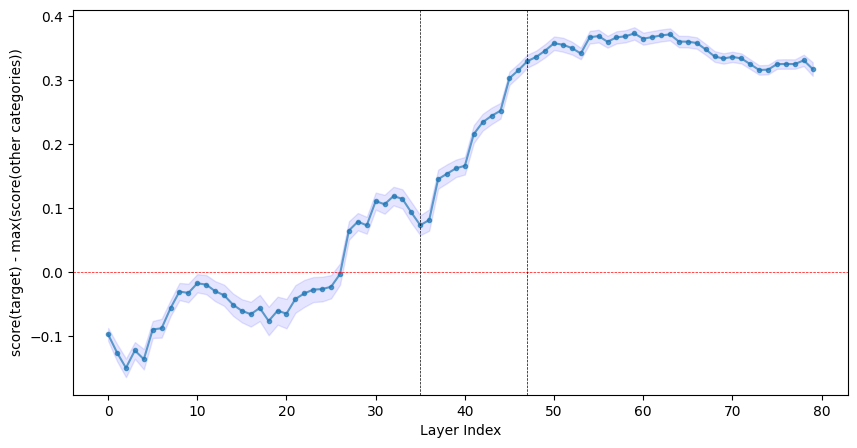

In [802]:
means = np.mean(evolution_of_scores, axis=0)
sterr = np.std(evolution_of_scores, axis=0) / np.sqrt(N_SAMPLES)

plt.figure(figsize=(10, 5))
plt.plot(
    range(len(means)),
    means,
    marker='o',
    alpha=0.7,
    markersize=3,
    label='Mean Score Difference'
)
plt.fill_between(
    range(len(means)),
    means - sterr,
    means + sterr,
    color='blue',
    alpha=0.1,
    label='Standard Error'
)

plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
plt.axvline(35, color='black', linestyle='--', linewidth=0.5)
plt.axvline(47, color='black', linestyle='--', linewidth=0.5)


plt.xlabel("Layer Index")
plt.ylabel("score(target) - max(score(other categories))")

### Steering

In [29]:
promote_concept = patch_sample.metadata["category"]
suppress_concept = clean_sample.metadata["category"]

promote_directions = probe_directions[promote_concept]
suppress_directions = probe_directions[suppress_concept]
beta = 1

tokenized = prepare_input(
    prompts=clean_sample.prompt,
    tokenizer=mt,
)

clean_hs = get_hs(
    mt=mt,
    input=tokenized,
    locations=[
        (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
    ],
    return_dict=True,
)
patch_hs = []
for layer_idx in range(34, 35):
    layer_name = mt.layer_name_format.format(layer_idx)
    promote_dir = promote_directions[layer_name].to(mt.dtype).to(mt.device)
    suppress_dir = suppress_directions[layer_name].to(mt.dtype).to(mt.device)

    orig_h = clean_hs[(layer_name, -1)].to(mt.dtype).to(mt.device)

    #! Doesn't work as expected (query_proj works on post-LN space. But the interventions are done on pre-LN space)
    # attn_module = baukit.get_module(
    #     mt._model,
    #     mt.attn_module_name_format.format(layer_idx + 1),
    # )
    # q_proj_weight_split = attn_module.q_proj.weight.view(
    #     N_HEADS, attn_module.head_dim, attn_module.q_proj.in_features
    # )

    # deltas = []
    # for head_idx in [19]:
    #     head_q_proj_weight = q_proj_weight_split[head_idx]
    #     with torch.no_grad():
    #         head_q_proj = head_q_proj_weight.to(torch.float32)
    #         # proj_matrix = head_q_proj.T @ torch.linalg.pinv(head_q_proj @ head_q_proj.T) @ head_q_proj
    #         # head_query_read = head_inp @ proj_matrix.to(mt.dtype).T
    #         U, S, Vt = torch.linalg.svd(head_q_proj, full_matrices=False)
    #         Vt = Vt.to(mt.dtype).to(head_inp.device)
    #         head_query_read = head_inp @ Vt.T @ Vt
        
    #     head_query_read = inverse_rms_norm(
    #         head_query_read[:, -1].squeeze(), input_ln.weight, input_ln.variance_epsilon
    #     ).to(mt.dtype).to(mt.device)
    #     h_suppress = (
    #         torch.dot(head_query_read, suppress_dir)
    #         / suppress_dir.norm() ** 2
    #         * suppress_dir
    #     )
    #     h_promote = (
    #         torch.dot(head_query_read, promote_dir)
    #         / promote_dir.norm() ** 2
    #         * promote_dir
    #     )
    #     deltas.append(
    #         h_promote - h_suppress
    #     )
    
    # patch_h = orig_h.clone()
    # for delta in deltas:
    #     patch_h += beta * delta

    # ! Uncommenting this will have the desired effect
    h_suppress = (
        torch.dot(orig_h, suppress_dir) / suppress_dir.norm() ** 2 * suppress_dir
    )
    h_promote = torch.dot(orig_h, promote_dir) / promote_dir.norm() ** 2 * promote_dir
    patch_h = orig_h + beta * (h_promote - h_suppress)

    patch_hs.append(
        PatchSpec(location=(layer_name, -1), patch=patch_h.to(mt.dtype).to(mt.device))
    )

steered_attn_matrices = get_attention_matrices(
    input=clean_tokenized, mt=mt, value_weighted=False, 
    patches=patch_hs
)

# for group_id in group_id_to_head_indices:
layer_idx = 35
for group_id in [19, 46]:
    frm = group_id_to_head_indices[group_id][0]
    to = group_id_to_head_indices[group_id][-1]
    print(
        f"Layer {layer_idx}, Group {group_id} (Heads {frm}-{to})"
    )
    attn_matrix = (
        torch.Tensor(
            steered_attn_matrices.attention_matrices[layer_idx, frm : to + 1]
        )
        .mean(dim=0)
        .squeeze()
    )

    tokenized = patch_tokenized if run_name == "corrupt" else clean_tokenized
    print(run_name, attn_matrix.shape, tokenized.input_ids.shape)

    visualize_attn_matrix(
        attn_matrix=attn_matrix,
        tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
        q_index=-1,
        start_from=1,
    )
    
    print("=" * 150)

interpret_logits(tokenizer=mt, logits=steered_attn_matrices.logits)

Layer 35, Group 19 (Heads 19-19)
obj_replaced torch.Size([47, 47]) torch.Size([1, 47])


Layer 35, Group 46 (Heads 46-46)
obj_replaced torch.Size([47, 47]) torch.Size([1, 47])


[PredictedToken(token=' Ted', prob=0.384765625, logit=18.625, token_id=23989, metadata=None),
 PredictedToken(token=' None', prob=0.2060546875, logit=18.0, token_id=2290, metadata=None),
 PredictedToken(token=' Lester', prob=0.125, logit=17.5, token_id=83758, metadata=None),
 PredictedToken(token=' Al', prob=0.06689453125, logit=16.875, token_id=1708, metadata=None),
 PredictedToken(token=' Gary', prob=0.05908203125, logit=16.75, token_id=24765, metadata=None)]